In [1]:
!pip install scanpy -q
!pip install scikit-optimize -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import shutil
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from keras_tuner import Hyperband

seed = 2023 # DO NOT CHANGE!

In [ ]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")
print(f"tensorflow version: {tf.__version__}")
print(f"keras tuner version: {kt.__version__}")

sklearn version: 1.2.2
numpy version: 1.25.2
pandas version: 2.0.3
matplotlib version: 3.7.1
scanpy version: 1.10.1
tensorflow version: 2.15.0
keras tuner version: 1.4.7


# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PBMC = sp.read_h5ad("/content/drive/MyDrive/Design/pbmc_multiome.h5ad")

In [ ]:
print(f"The data has {PBMC.n_obs} observations and {PBMC.n_vars} features.")

The data has 9641 observations and 19607 features.


In [ ]:
PBMC.X

<9641x19607 sparse matrix of type '<class 'numpy.float64'>'
	with 73296936 stored elements in Compressed Sparse Row format>

In [ ]:
PBMC.obs['predicted.id']

AAACAGCCAACAACAA-1      CD4 TCM
AAACAGCCAAGGACCA-1    CD4 Naive
AAACAGCCACAATGCC-1      CD8 TEM
AAACAGCCATGAGCAG-1      CD4 TCM
AAACATGCAAGATTCT-1      CD4 TCM
                        ...    
TTTGTGGCATTAGGTT-1           NK
TTTGTGGCATTGCGTA-1      CD8 TEM
TTTGTGTTCAAGCGCC-1    CD4 Naive
TTTGTGTTCGTTTCCA-1    CD14 Mono
TTTGTTGGTACCCACC-1      CD4 TCM
Name: predicted.id, Length: 9641, dtype: object

9641 number of cells, with 27 total cell types


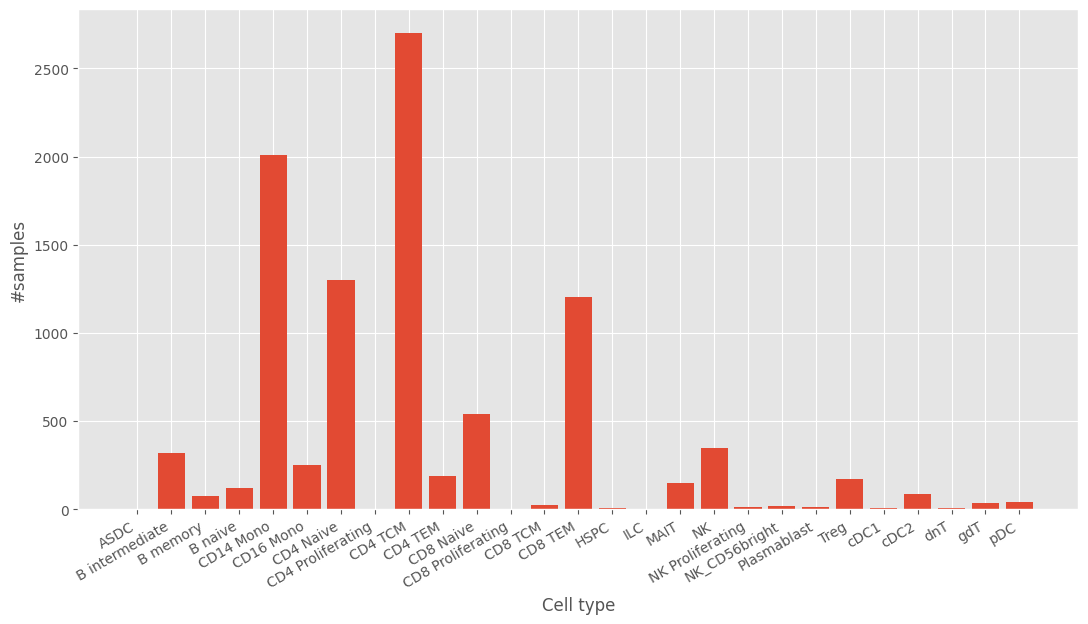

In [5]:
cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

# Filtering + Train/Test Split

In [6]:
cutoff = 0.001
# Cut off

cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(PBMC.obs['predicted.id'])<cutoff]
print(bad_types)

bad_types_mask = np.invert(np.isin(PBMC.obs['predicted.id'], bad_types))
X = PBMC.X[bad_types_mask]
Y = PBMC.obs['predicted.id'][bad_types_mask]

print(Y.shape)

['ASDC' 'CD4 Proliferating' 'CD8 Proliferating' 'HSPC' 'ILC' 'cDC1' 'dnT']
(9619,)


9619 number of cells, with 20 total cell types


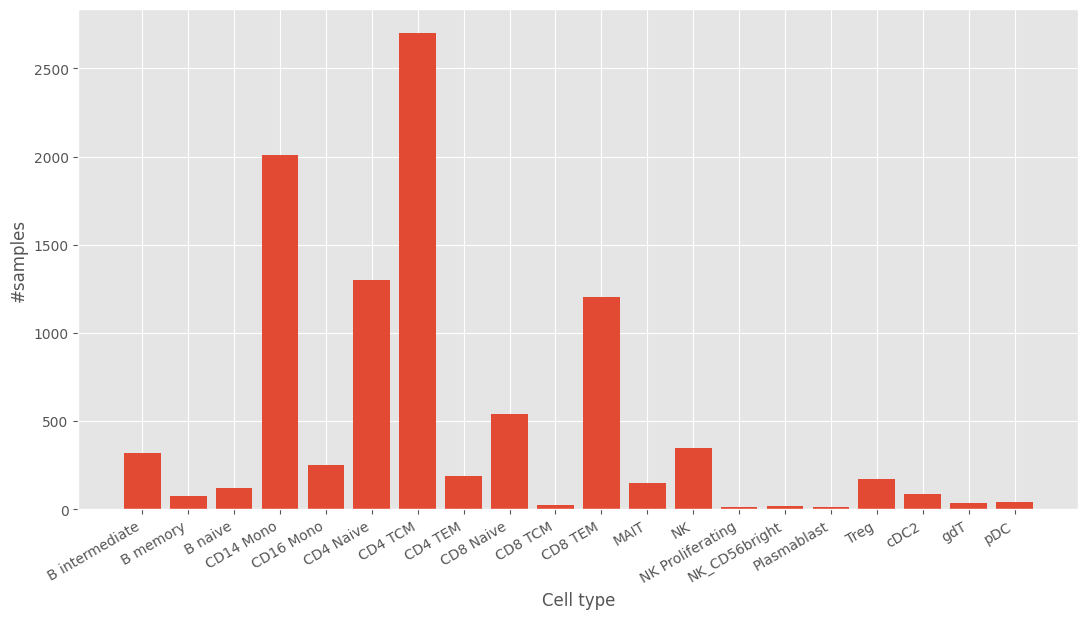

In [7]:
cell_types, type_numbers = np.unique(Y, return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [13]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed, stratify=None)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1333, random_state=seed, stratify=Y_train_val)


n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

print(f"{n_train} train samples")
print(f"{n_val} validation samples")
print(f"{n_test} test samples")
print(f"{n_train/(n_train+n_val+n_test)*100:.2f}% of samples used for training")
print(f"{n_val/(n_train+n_val+n_test)*100:.2f}% of samples used for validation")
print(f"{n_test/(n_train+n_val+n_test)*100:.2f}% of samples used for testing")

6252 train samples
962 validation samples
2405 test samples
65.00% of samples used for training
10.00% of samples used for validation
25.00% of samples used for testing


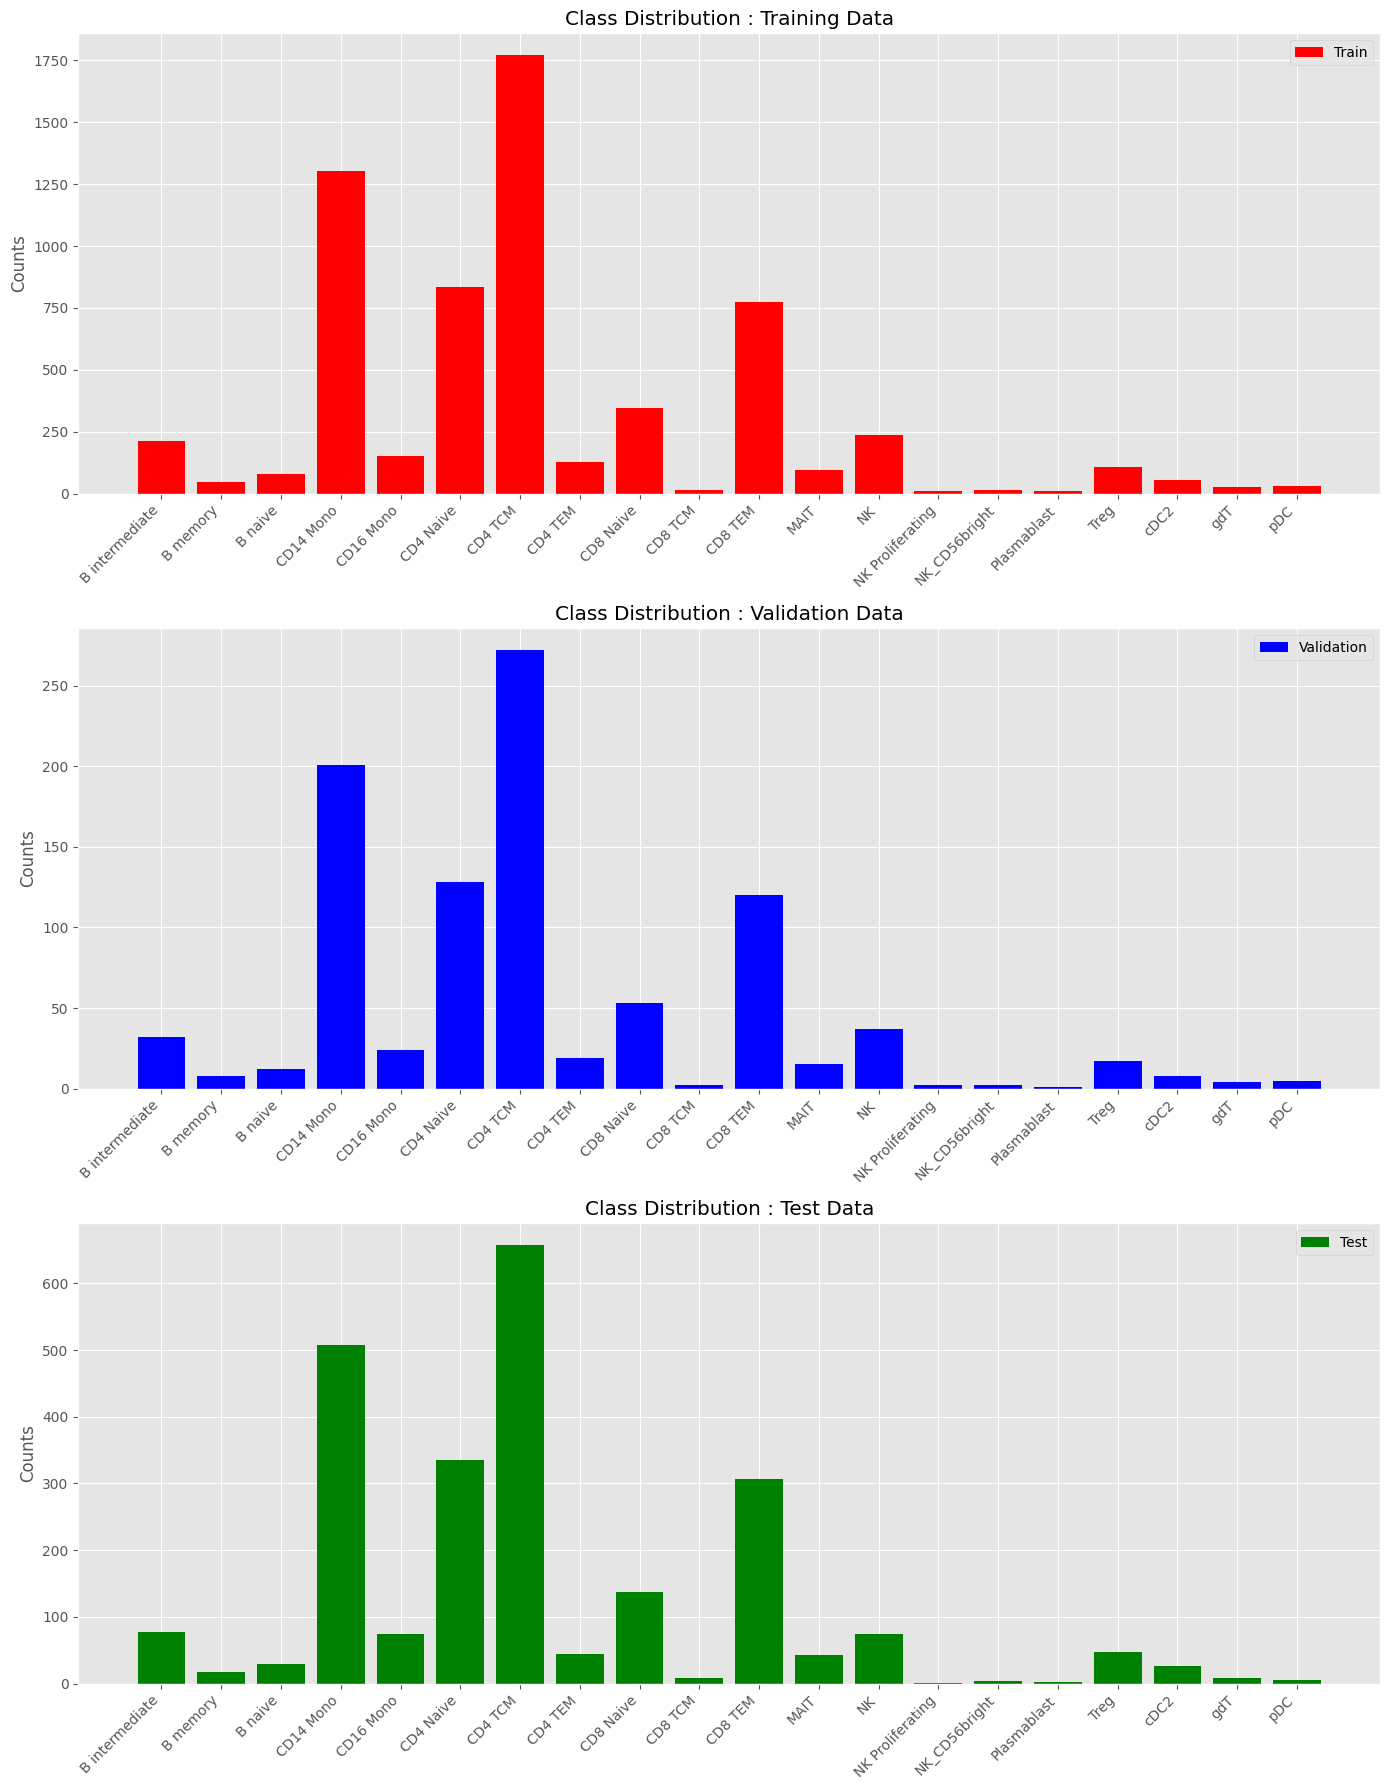

In [14]:
def get_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

train_dist = get_class_distribution(Y_train)
val_dist = get_class_distribution(Y_val)
test_dist = get_class_distribution(Y_test)


all_classes = sorted(set(train_dist.keys()).union(set(val_dist.keys()), set(test_dist.keys())))
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}

def prepare_plot_data(distribution):
    indices = []
    counts = []
    for cls in all_classes:
        indices.append(class_to_index[cls])
        counts.append(distribution.get(cls, 0))
    return indices, counts

train_indices, train_counts = prepare_plot_data(train_dist)
val_indices, val_counts = prepare_plot_data(val_dist)
test_indices, test_counts = prepare_plot_data(test_dist)

fig, ax = plt.subplots(3, 1, figsize=(14, 18))

ax[0].bar(train_indices, train_counts, color='r', label='Train')
ax[1].bar(val_indices, val_counts, color='b', label='Validation')
ax[2].bar(test_indices, test_counts, color='g', label='Test')

ax[0].set_title('Class Distribution : Training Data')
ax[1].set_title('Class Distribution : Validation Data')
ax[2].set_title('Class Distribution : Test Data')

ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[2].set_ylabel('Counts')

ax[0].legend()
ax[1].legend()
ax[2].legend()

for a in ax:
    a.set_xticks(range(len(all_classes)))
    a.set_xticklabels(all_classes, rotation=45, ha='right')
    a.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
plt.show()

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit(Y)

Y_train_encoded = label_encoder.transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
Y_full = label_encoder.transform(Y)

num_classes = len(np.unique(Y_train_encoded))
print("Number of classes:", len(label_encoder.classes_))

Number of classes: 20


In [16]:
def sparse_to_dense(sparse):
    return tf.convert_to_tensor(sparse.todense(), dtype=tf.float32)

X_train_dense = sparse_to_dense(X_train)
X_val_dense = sparse_to_dense(X_val)
X_test_dense = sparse_to_dense(X_test)
X_full_dense = sparse_to_dense(X)

# Model training

In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

In [12]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

## MLP

### Reload tuner

In [ ]:
dest_folder = '/content/PBMC_MLP_final'
src_folder = '/content/drive/MyDrive/Design/PBMC_MLP_final'

shutil.copytree(src_folder, dest_folder)

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

In [18]:
with strategy.scope():
    def model_builder(hp):
        model = Sequential()
        units = hp.Int('units', min_value=len(np.unique(Y_train)), max_value=7*len(np.unique(Y_train)), step=len(np.unique(Y_train)))
        hp_alpha = hp.Float('alpha', min_value=0.0, max_value=0.1, step=0.01)
        hp_batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512])
        model.add(Dense(units=units, activation='relu', kernel_regularizer=l2(hp_alpha), input_dim=X_train_dense.shape[1]))
        model.add(Dense(num_classes, activation='softmax'))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        if hp_optimizer == 'adam':
            optimizer = Adam(learning_rate=hp_learning_rate)
        else:
            hp_momentum = hp.Float('momentum', min_value=0.5, max_value=0.99, step=0.1)
            optimizer = SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])
        return model

In [ ]:
with strategy.scope():
    tuner = Hyperband(
        model_builder,
        objective='val_sparse_categorical_accuracy',
        max_epochs=150,
        factor=3,
        hyperband_iterations=1,
        directory='PBMC_MLP',
        project_name='PBMC_MLP',
        overwrite=False
    )
    tuner.search(X_train_dense, Y_train_encoded, epochs=10, validation_data=(X_val_dense, Y_val_encoded), callbacks=[reduce_lr, early_stopping])

In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [23]:
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal alpha for L2 regularization: {best_hps.get('alpha')}")
print(f"Optimal batch size: {best_hps.get('batch_size')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
print(f"Optimal optimizer: {best_hps.get('optimizer')}")
if best_hps.get('optimizer') == 'sgd':
    print(f"Optimal momentum for SGD: {best_hps.get('momentum')}")

Optimal number of units: 60
Optimal alpha for L2 regularization: 0.03
Optimal batch size: 256
Optimal learning rate: 0.001
Optimal optimizer: sgd
Optimal momentum for SGD: 0.9


Backup Tuner

In [24]:
src_folder = '/content/PBMC_MLP'
dest_folder = '/content/drive/MyDrive/Design/PBMC_MLP'
shutil.copytree(src_folder, dest_folder)

'/content/drive/MyDrive/Design/PBMC_MLP'

Combine training and validation for final model training

In [19]:
X_train_full = tf.concat([X_train_dense, X_val_dense], axis=0)
Y_train_full = np.concatenate([Y_train_encoded, Y_val_encoded], axis=0)

Build the model with the best hyperparameters


In [25]:
def build_model(best_hps):
    with strategy.scope():
        model = Sequential([
            Dense(units=best_hps.get('units'), activation='relu',
                  kernel_regularizer=l2(best_hps.get('alpha')),
                  input_dim=X_train_full.shape[1]),
            Dense(num_classes, activation='softmax')
        ])

        if best_hps.get('optimizer') == 'adam':
            optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
        else:
            optimizer = SGD(learning_rate=best_hps.get('learning_rate'), momentum=best_hps.get('momentum'))

        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])
    return model

model = build_model(best_hps)

Train the final model for 132 epochs.

In [ ]:
model.fit(X_train_full, Y_train_full, epochs=132, batch_size=best_hps.get('batch_size'))

# Predictions

In [27]:
test_loss, test_accuracy = model.evaluate(X_test_dense, Y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

76/76 [==============================] - 0s 3ms/step - loss: 0.7475 - sparse_categorical_accuracy: 0.8249
Test Loss: 0.747521162033081
Test Accuracy: 0.8249480128288269


In [28]:
test_pred = model.predict(X_test_dense).argmax(axis=1)
train_pred = model.predict(X_train_dense).argmax(axis=1)
full_pred = model.predict(X_full_dense).argmax(axis=1)

print("==== Accuracy with Subtypes ====")
print(f"Train accuracy: {accuracy_score(Y_train_encoded, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test_encoded, test_pred):.5f}")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train_encoded, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test_encoded, test_pred):.5f}")

301/301 [==============================] - 1s 2ms/step
==== Accuracy with Subtypes ====
Train accuracy: 1.00000
Test accuracy: 0.82495
Balanced Train Accuracy: 1.00000
Balanced Test Accuracy: 0.53313


In [29]:
test_pred_labels = label_encoder.inverse_transform(test_pred)
train_pred_labels = label_encoder.inverse_transform(train_pred)
full_pred_labels = label_encoder.inverse_transform(full_pred)

pred_pickle = {
    'test_pred_labels': test_pred_labels,
    'train_pred_labels': train_pred_labels,
    'full_pred_labels': full_pred_labels
}

file_path = '/content/drive/MyDrive/Design/PBMC/pbmc_pred_final.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(pred_pickle, file)

In [30]:
print(classification_report(Y_test, test_pred_labels))

                  precision    recall  f1-score   support

  B intermediate       0.79      0.92      0.85        78
        B memory       0.91      0.59      0.71        17
         B naive       1.00      0.59      0.74        29
       CD14 Mono       0.93      0.98      0.95       507
       CD16 Mono       0.94      0.89      0.92        74
       CD4 Naive       0.74      0.71      0.73       335
         CD4 TCM       0.78      0.89      0.83       657
         CD4 TEM       0.33      0.02      0.04        44
       CD8 Naive       0.91      0.85      0.88       137
         CD8 TCM       0.00      0.00      0.00         8
         CD8 TEM       0.76      0.81      0.78       306
            MAIT       0.91      0.72      0.81        43
              NK       0.81      0.88      0.84        74
NK Proliferating       0.00      0.00      0.00         1
   NK_CD56bright       0.00      0.00      0.00         4
     Plasmablast       0.00      0.00      0.00         3
            T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model saving and reloading

In [ ]:
model_save_path = '/content/drive/MyDrive/Design/PBMC/PBMC_MLP_final.keras'
model.save(model_save_path)

Load the final model if needed

In [ ]:
model_load_path = '/content/drive/MyDrive/Design/PBMC/PBMC_MLP_final.keras'
loaded_model = load_model(model_load_path)

if best_hps.get('optimizer') == 'adam':
    optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
else:
    optimizer = SGD(learning_rate=best_hps.get('learning_rate'), momentum=best_hps.get('momentum'))

loaded_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])